In [ ]:
!pip install torchmetrics
!pip install lpips

In [ ]:
import numpy as np
import os
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader,random_split
from PIL import Image
import torch.nn as nn
from torch.optim import Adam, AdamW
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import cv2
import matplotlib.pyplot as plt
from net import UNet, Discriminator
from utils import sample_and_infer, compute_metrics
from dataset import OCTDataset
import lpips
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
torch.cuda.empty_cache()
import gc
gc.collect()

120

### Define Global Variables

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2
lr = 2e-4
lambda_l1 = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Adversarial loss (Binary Cross-Entropy)
criterion_gan = nn.BCEWithLogitsLoss()
#adversarial_loss = nn.MSELoss()
# Initialize metric
ssim = SSIM(data_range=2.0).to(DEVICE)  # Data range is 2.0 for [-1, 1]
# L1 loss (Pixel-wise difference)
criterion_l1 = nn.L1Loss()
#criterion = nn.MSELoss()
# Initialize models
generator = UNet(in_channels=1, out_channels=1).to(DEVICE)
discriminator = Discriminator(in_channels=2).to(DEVICE)



In [10]:

#scheduler = StepLR(optimizer, step_size=40, gamma=0.3)

# Load dataset
data_dir = "/content/drive/MyDrive/dataset_tesi"
dataset = OCTDataset(data_dir)

# Split into train and validation sets (80% train, 20% validation)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Training Loop

In [ ]:
criterion_gan = nn.BCEWithLogitsLoss()
criterion_l1 = nn.L1Loss()

optimizer_g = Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

generator.to(DEVICE)
discriminator.to(DEVICE)
train_losses_g = []
train_losses_d = []
train_losses_l1 = []
test_losses_g = []
test_losses_l1 = []
test_ssim_scores = []
for epoch in range(EPOCHS):
      epoch_loss_g = 0.0
      epoch_loss_d = 0.0
      epoch_loss_l1 = 0.0
      for a_scan, real_b_scan in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]", leave=False):
            a_scan, real_b_scan = a_scan.to(DEVICE), real_b_scan.to(DEVICE)
            batch_size = a_scan.size(0)

            # Real and Fake Labels
            real_labels = torch.ones((batch_size, 1, 126, 126), device=DEVICE)  # PatchGAN output size
            fake_labels = torch.zeros((batch_size, 1, 126, 126), device=DEVICE)

            # --------------------
            # Train Generator
            # --------------------
            generator.train()
            optimizer_g.zero_grad()
            fake_b_scan = generator(a_scan)

            # Adversarial loss (make discriminator think it's real)
            #print(f"Ascan : {a_scan.shape}, Bscan {fake_b_scan.shape}")
            combined_input = torch.cat((a_scan, fake_b_scan), dim=1)

            pred_fake = discriminator(combined_input)
            loss_gan = criterion_gan(pred_fake, real_labels)

            # L1 loss (pixel-wise similarity)
            loss_l1 = criterion_l1(fake_b_scan, real_b_scan) * lambda_l1

            # Total Generator Loss
            loss_g = loss_gan + loss_l1
            loss_g.backward()
            optimizer_g.step()

            # --------------------
            # Train Discriminator
            # --------------------
            discriminator.train()
            optimizer_d.zero_grad()

            # Real images loss
            real_input = torch.cat((a_scan, real_b_scan), dim=1)
            pred_real = discriminator(real_input)
            loss_real = criterion_gan(pred_real, real_labels)

            # Fake images loss
            pred_fake = discriminator(combined_input.detach())
            loss_fake = criterion_gan(pred_fake, fake_labels)

            # Total Discriminator Loss
            loss_d = (loss_real + loss_fake) * 0.5
            loss_d.backward()
            # Accumulate epoch losses
            epoch_loss_g += loss_g.item()
            epoch_loss_d += loss_d.item()
            epoch_loss_l1 += loss_l1.item()
            optimizer_d.step()

      epoch_loss_g /= len(train_loader)
      epoch_loss_d /= len(train_loader)
      epoch_loss_l1 /= len(train_loader)
      generator.eval()
      with torch.no_grad():
            test_loss_g = 0.0
            test_loss_l1 = 0.0
            test_ssim = 0.0

            for a_scan, real_b_scan in val_loader:
                batch_size = a_scan.size(0)
                real_labels = torch.ones((batch_size, 1, 126, 126), device=DEVICE)
                a_scan, real_b_scan = a_scan.to(DEVICE), real_b_scan.to(DEVICE)
                fake_b_scan = generator(a_scan)

                combined_input = torch.cat((a_scan, fake_b_scan), dim=1)
                loss_gan = criterion_gan(discriminator(combined_input), real_labels)
                loss_l1 = criterion_l1(fake_b_scan, real_b_scan) * lambda_l1
                ssim_value = ssim(fake_b_scan, real_b_scan)

                test_ssim += ssim_value.item()
                test_loss_g += loss_gan.item()
                test_loss_l1 += loss_l1.item()

            test_loss_g /= len(val_loader)
            test_loss_l1 /= len(val_loader)
            test_ssim /= len(val_loader)

      # Store losses for plotting
      train_losses_g.append(epoch_loss_g)
      train_losses_d.append(epoch_loss_d)
      train_losses_l1.append(epoch_loss_l1)
      test_losses_g.append(test_loss_g)
      test_losses_l1.append(test_loss_l1)
      test_ssim_scores.append(test_ssim)

      print(f"Epoch [{epoch+1}/{EPOCHS}] Summary - Loss_G: {epoch_loss_g:.4f}, TEST_Loss_G: {test_loss_g:.4f}, Loss_D: {epoch_loss_d:.4f}, L1: {epoch_loss_l1:.4f}, TEST_Loss_L1: {test_loss_l1}")

print("Training Completed!")


In [ ]:
torch.save(generator.state_dict(), "/content/drive/MyDrive/saves_from_training/models/best_pix2pix_001_dict.pth")
torch.save(generator, "/content/drive/MyDrive/saves_from_training/models/best_pix2pix_001.pth")

### Plots of Losses and Metrics

In [ ]:
#Plot of Adversarial and L1 Testing Loss
plt.figure(figsize=(8, 5))
plt.plot(test_loss_g, label="Adversarial Loss", color="red", linewidth=2)
plt.plot(test_loss_l1, label="L1 Loss", color="blue", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Adversarial and L1 Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

#Plot of Generator testing and training loss
test_g_losses = test_loss_g + test_loss_l1
min_testing_loss_epoch = np.argmin(test_g_losses)
min_testing_loss_value = test_g_losses[min_testing_loss_epoch]
plt.figure(figsize=(8, 5))
plt.scatter(min_testing_loss_epoch,min_testing_loss_value, color="red", s=80, zorder=3, label="Lower testing loss")
plt.text(min_testing_loss_epoch+5,min_testing_loss_value+2, f"Model Saved Here: {min_testing_loss_value:.3f}",
         fontsize=12, color="red", ha="center", fontweight="bold")
plt.plot(test_loss_g + test_loss_l1, label="Testing Loss", color="red", linewidth=2)
plt.plot(train_losses_g, label="Training Loss", color="blue", linewidth=2, linestyle = "dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator Training and Testing Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#SSIM Plot
plt.figure(figsize=(10, 5))
plt.plot(test_ssim_scores , label='SSIM', color = "purple",linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Test SSIM', fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### Model Evaluation

In [12]:
model = torch.load("/content/drive/MyDrive/saves_from_training/models/best_pix2pix_001.pth", weights_only=False).to(DEVICE)
model.eval()

UNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=Tr

Make inference with 2 random sample

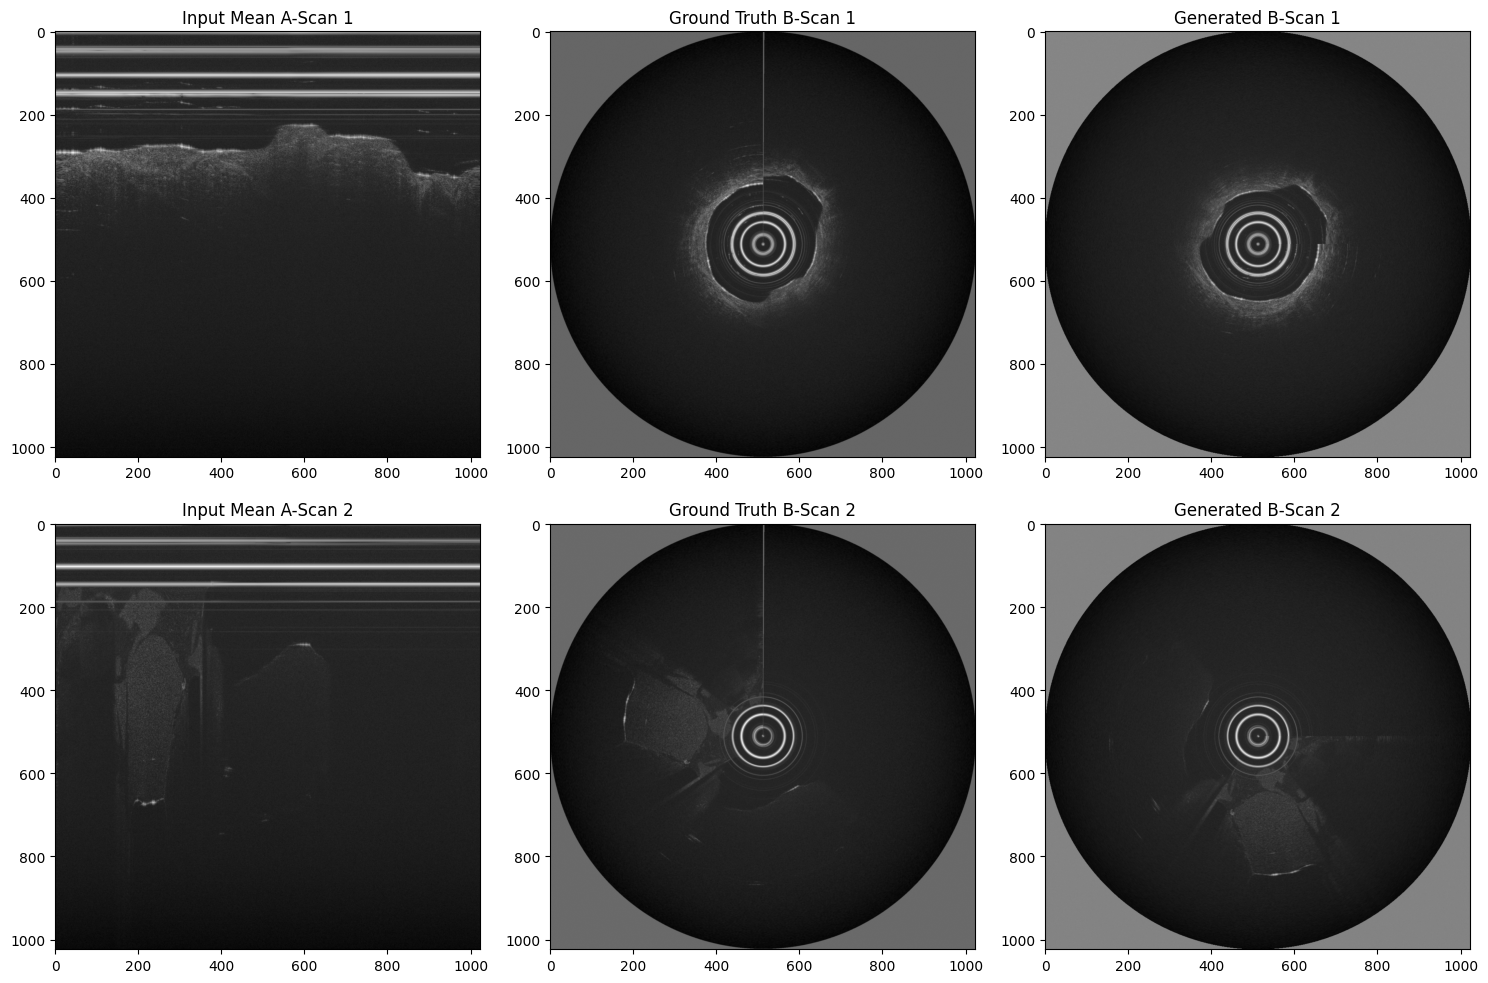

In [13]:
sample_and_infer(model, dataset, DEVICE)

Evaluate the model on 2 metrics

In [ ]:
#Metrics computation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

lpips_loss = lpips.LPIPS(net='vgg').to(DEVICE)  # Use a VGG-based perceptual metric
ssim = SSIM(data_range=2.0).to(DEVICE)
#gen = UNet().to(DEVICE)
#gen.load_state_dict(torch.load("/content/drive/MyDrive/saves_from_training/models/bestbest_unet_dict.pth", weights_only=True))
_, val_dataset = random_split(dataset, [0.8,0.2])
len_data = len(val_dataset)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
compute_metrics(model, val_loader, lpips_loss, ssim, len_data, DEVICE)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


/usr/local/lib/python3.11/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

SSIM Value is: 0.599
LPIPS Value is: 0.374
